In [17]:
%matplotlib inline
from __future__ import print_function
from torch.autograd import Variable
from random import randint
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

In [18]:
images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) #reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

In [19]:
for k in range(len(labels)): #push other classes to -1
    if labels[k] != 0:
        labels[k] = -1
    else:
        labels[k] = 1
        
        
# split data
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

From introduction-to-data.ipynb, we know that label = 0 represents the apple class of images. There are also 10000 apple images in the dataset out of 50000. Thus, if we flip a coin, we have a 1/2 chance of guessing apple, and 1/2 chance of guessing not apple. If we guess apple, we have a 1/5 chance of getting the guess correct. If we guess not apple, we have a 4/5 chance of getting the guess correct. So the accuracy would be (1/2)(1/5)+(1/2)(4/5) = .5 = 50% accuracy.

If we use a majority-vote classifier, we would obtain an accuracy of 20%. This is because there is no majority label in the data, so each is equally likely (1/5). Thus we will predict one label only for all the examples, and each label occurs with probability 1/5, so we will classify 20% of the examples properly.

In [20]:
class Perceptron():
    
    def __init__(self, learning_rate, iterations):
        self.num_input_features = None
        self.lr = learning_rate #learning rate
        self.iterations = iterations #num iterations
        self.count = 0
        self.num_iterations_vals = []
        self.accuracy_vals_train = []
        self.accuracy_vals_dev = []
        self.total_iterations = 0

    def accuracy(self, y, y_hat):
        return (y == y_hat).astype(np.float).mean()
        
    def fit(self, X, Y, X_dev, Y_dev):
        temp = torch.FloatTensor(X.shape[1]).zero_()
        self.w = Variable(temp, requires_grad=True)
        for j in range(self.iterations): #keep looping for iterations amount of times
            for i in range(X.shape[0]):
                if (self.count == 100): # every 100 iterations, compute accuracy
                    self.total_iterations += 100
                    #print(self.total_iterations)
                    self.count = 0
                    y_hat1 = np.zeros(1000)
                    y_actual = np.zeros(1000)
                    y_hat_dev = np.zeros(1000)
                    y_actual_dev = np.zeros(1000)
                    for z in range(1000): # accuracy over 1000 examples
                        rand_int = randint(0, 39999) # random index for train
                        rand_int_dev = randint(0, 4999) # random index for dev
                        dot1 = torch.dot(self.w.data, X[rand_int]) # train prediction 
                        dot2 = torch.dot(self.w.data, X_dev[rand_int_dev]) # dev prediction
                        y_actual[z] = Y[rand_int]
                        y_actual_dev[z] = Y_dev[rand_int_dev]
                        if dot1 < 0: # if >= 0, then apple
                            y_hat1[z] = -1
                        else:
                            y_hat1[z] = 1
                        if dot2 < 0:
                            y_hat_dev[z] = -1
                        else:
                            y_hat_dev[z] = 1
                    self.num_iterations_vals.append(self.total_iterations) # for the plots
                    self.accuracy_vals_train.append(self.accuracy(y_actual, y_hat1))
                    self.accuracy_vals_dev.append(self.accuracy(y_actual_dev, y_hat_dev))

                x = Variable(X[i])
                y = Variable(torch.FloatTensor([Y[i]]))
                y_hat = self.w.dot(x) # prediction
                loss = torch.max(Variable(torch.FloatTensor([0.0])), -1 * y * y_hat) # loss function Perceptron
                # print(loss)
                loss.backward()
                self.w.data = self.w.data - self.lr * self.w.grad.data # update
                self.w.grad.data.zero_() # set gradient to 0
                self.count += 1
        return self


In [21]:
p = Perceptron(.01, 1)
train_data = train_data.type(torch.FloatTensor)
dev_data = dev_data.type(torch.FloatTensor)
p.fit(train_data, train_labels, dev_data, dev_labels)

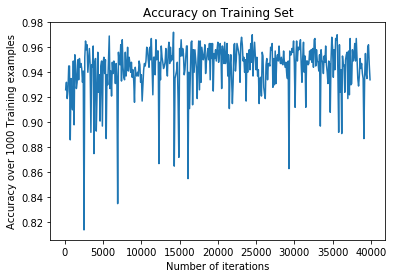

In [22]:
plt.plot(p.num_iterations_vals, p.accuracy_vals_train)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

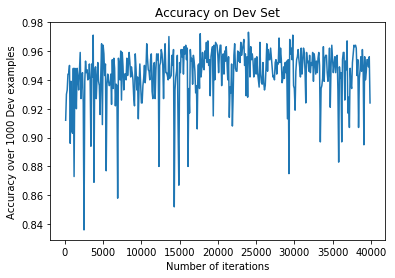

In [23]:
plt.plot(p.num_iterations_vals, p.accuracy_vals_dev)
plt.title("Accuracy on Dev Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Dev examples")
plt.show()

It does not appear as though there is any overfitting occuring. The accuracy increases in the first thousand iterations/updates, and then it basically flatlines at around 95-96% accuracy. If there was overfitting, we would probably see a decrease in accuracy with continued iteration, but that does not appear to be happening. 